In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'
!ls

/content/drive/My Drive/Colab Notebooks
backup	curso_pandas  db  pd_1_0


In [ ]:
dir_pandas = '/content/drive/My Drive/Colab Notebooks/db'
dir_pandas

'/content/drive/My Drive/Colab Notebooks/db'

In [ ]:
import pandas as pd

In [ ]:
pd.__version__

'0.25.3'

In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
from uuid import uuid4
import os
import time
import tracemalloc

In [ ]:
def generate_dataset(n_rows, num_count, cat_count, max_nan=0.1, max_cat_size=100):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    The categorical features are generated as random uuid4 strings with 
    cardinality C where 2 <= C <= max_cat_size.
    
    Also, a max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    def generate_categories():
        
        category_size = np.random.randint(2, max_cat_size)
        return [str(uuid4()) for _ in range(category_size)]
    
    for col in range(num_count):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
        
    for col in range(cat_count):
        name = f'c{col}'
        cats = generate_categories()
        values = np.array(np.random.choice(cats, n_rows, replace=True), dtype=object)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'object'
    
    return pd.DataFrame(dataset), types

In [ ]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [ ]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = getattr(pd, f'read_{fmt}')
    return save, load

In [ ]:
def benchmark(list_of_formats,
              data_size=1000000,
              n_num=15,
              n_cat=15,
              n_rounds=20,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    n = 1
    cnt = 0

    for j in range(n_rounds):
        print('Benchmarking round # {}'.format(j))
        #print('generating dataset...')
        dataset, _ = generate_dataset(data_size, n_num, n_cat)
        
        if as_category:
            #print('converting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        for case in list_of_formats:
              fmt, params = case if len(case) == 2 else (case[0], {})
            
              print('testing format: {}'.format(fmt))
              filename = 'random.{}'.format(fmt)
              save, load = get_save_load(dataset, fmt)
              results = {}
              
              results['format'] = fmt
              results['filename'] = filename

              tracemalloc.start()
              start = time.time()
              for i in range(n):
                  save(dir_pandas + filename, **params)
              end = (time.time()- start) / n
              current, peak = tracemalloc.get_traced_memory()
              tracemalloc.stop()

              results['size_mb'] = size_of(dir_pandas + filename)
              results['save_ram_mb'] = current / 10**6
              results['save_ram_peak_mb'] = peak / 10**6
              results['save_time'] = end
              
              tracemalloc.start()
              start = time.time()
              for i in range(n):
                  _ = load(filename)
              end = (time.time()- start) / n
              current, peak = tracemalloc.get_traced_memory()
              tracemalloc.stop()

              results['load_ram_mb'] = current / 10**6
              results['load_ram_peak_mb'] = peak / 10**6
              results['load_time'] = end

              results['run_no'] = j

              cnt += 1
              run = pd.DataFrame(results,[cnt])
              runs.append(run)
            
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark


In [ ]:
formats = [
    ('json',),
    ('csv', {'index': None}),
    ('hdf', {'key': 'data', 'format': 'table'}),
    ('pickle',),
    #('msgpack',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Strings

In [ ]:
results_io = benchmark(formats,
              data_size=100000,
              n_num=15,
              n_cat=15,
              n_rounds=1,
              as_category=False)

Benchmarking round # 0
testing format: json
testing format: csv
testing format: hdf
testing format: pickle
testing format: feather
testing format: parquet


In [ ]:
avg = results_io.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_mb,save_ram_peak_mb,save_time,load_ram_mb,load_ram_peak_mb,load_time
0,csv,76.58,0.020431,13.496845,6.708381,24.283428,48.300520,1.245796
1,feather,65.95,0.061709,0.103927,0.408491,24.073244,24.081095,0.243123
2,hdf,66.90,12.029854,199.646839,2.340985,335.242716,378.933460,1.941241
3,json,94.00,0.814209,233.581957,1.431729,144.733795,1065.407778,4.480983
4,parquet,15.04,0.021925,0.885827,0.346414,24.094453,24.110855,0.195544
5,pickle,64.68,0.013195,215.861380,0.749980,146.032663,176.244113,0.970435


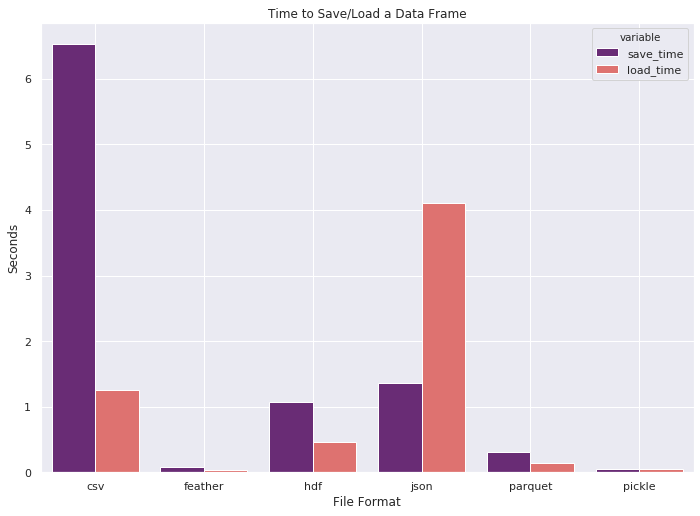

In [ ]:
io_speed = avg[~avg['format'].isin([])][['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed, palette="magma")
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame')
ax.grid(True)

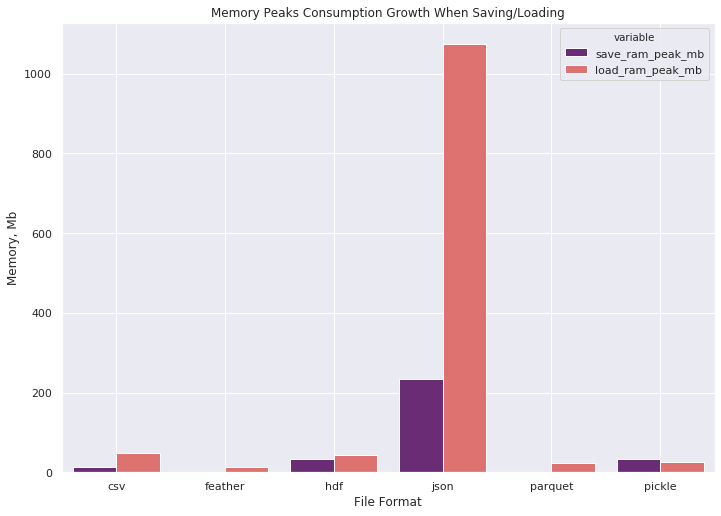

In [ ]:
mem_size = avg[~avg['format'].isin([])][['format', 'save_ram_peak_mb', 'load_ram_peak_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size, palette="magma")
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Peaks Consumption Growth When Saving/Loading')
ax.grid(True)

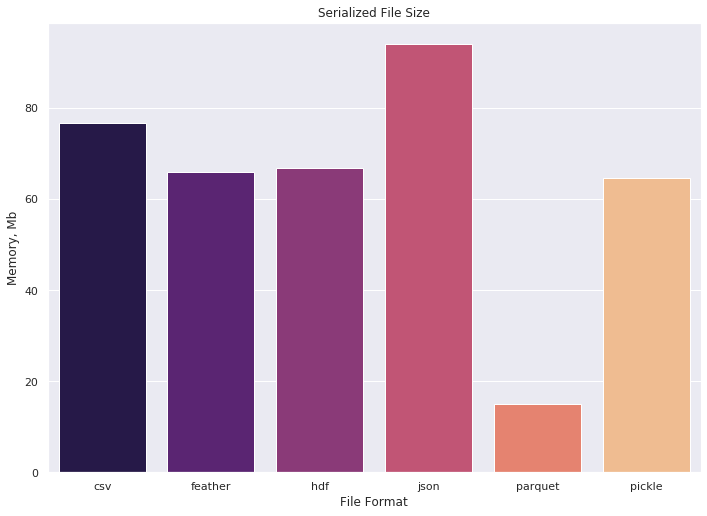

In [ ]:
ax = sns.barplot(x='format', y='size_mb', data=avg, palette="magma")
_ = ax.set_ylabel('Memory, Mb')
_ = ax.set_xlabel('File Format')
_ = ax.set_title('Serialized File Size')

# Categorias

In [ ]:
results_io_cat = benchmark(formats,
              data_size=100000,
              n_num=15,
              n_cat=15,
              n_rounds=1,
              as_category=True)

Benchmarking round # 0
testing format: json
testing format: csv
testing format: hdf
testing format: pickle
testing format: feather
testing format: parquet


In [ ]:
avg = results_io_cat.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_mb,save_ram_peak_mb,save_time,load_ram_mb,load_ram_peak_mb,load_time
0,csv,77.38,0.028869,13.507343,6.529927,24.310116,48.327208,1.260878
1,feather,13.09,0.068804,0.303033,0.083436,12.113894,12.121842,0.041463
2,hdf,18.25,0.495662,32.310204,1.071665,29.672178,43.564825,0.465293
3,json,94.57,0.824381,234.204345,1.355046,149.845604,1074.165543,4.107476
4,parquet,15.09,0.024861,0.893393,0.313584,24.098545,24.115486,0.141382
5,pickle,12.91,0.020097,34.067053,0.054402,13.608012,25.693748,0.050316


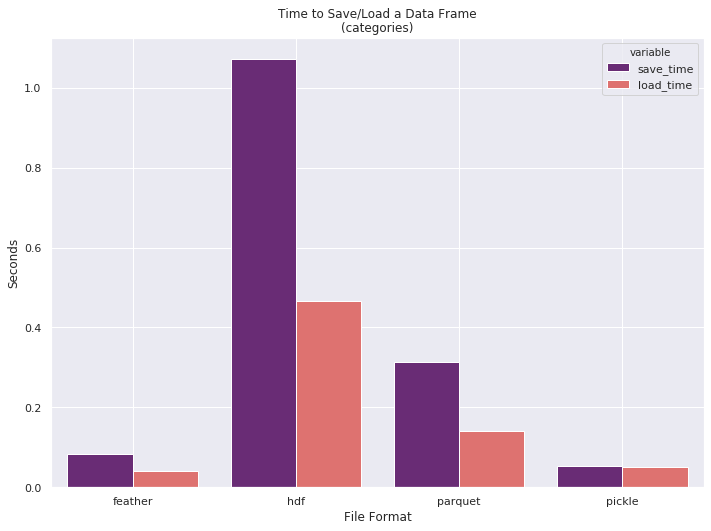

In [ ]:
io_speed = avg[~avg['format'].isin(['json','csv'])][['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed, palette="magma")
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories)')
ax.grid(True)

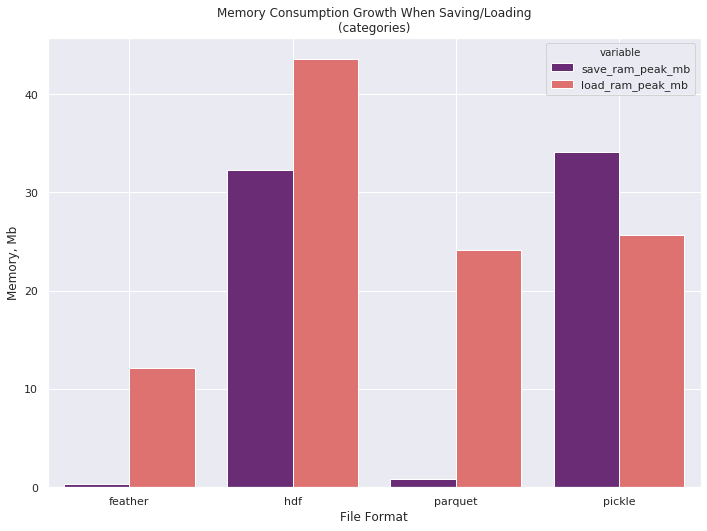

In [ ]:
mem_size = avg[~avg['format'].isin(['json','csv'])][['format', 'save_ram_peak_mb', 'load_ram_peak_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size, palette="magma")
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories)')
ax.grid(True)

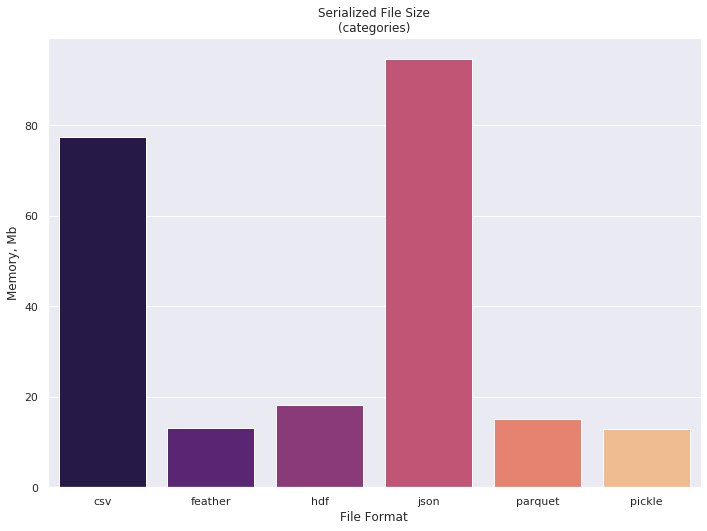

In [ ]:
ax = sns.barplot(x='format', y='size_mb', data=avg, palette="magma")
_ = ax.set_ylabel('Memory, Mb')
_ = ax.set_xlabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories)')

Curso: Análisis de datos con Pandas				
Clase: I/O Tools				
Nivel: Intermedio				
Keywords: Load - Save - Time - Size - DataFrame - Input - Output - Tools				
				
Abstract:				
En esta clase te enseñaremos sobre diversos formatos de almacenamiento de datos y cómo elegir el formato eficiente que se adapte a tus necesidades.				
				
				
				
				

Conclusiones:

CSV y formatos String : Son simples, requieren alto costo computacional y algo lentos.

HDF : Gran soporte, adecuado para grandes cantidades de datos, rápido a costo de alto costo computacional.

Parquet : Puede igualar a hdf e inclusive trabajar por chunks y en paralelo.

Pickle : Es práctico pero lento con grandes cantidades de datos.